In [40]:
#import all necessary libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential, load_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras.utils import plot_model

In [44]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   
2024-08-06  161.710007  165.080002  158.539993  161.929993  161.929993   
2024-08-07  166.550003  167.580002  161.429993  162.770004  162.770004   
2024-08-08  165.169998  166.690002  162.550003  165.800003  165.800003   
2024-08-09  166.399994  168.550003  165.850006  166.940002  166.940002   
2024-08-12  168.139999  168.550003  166.110001  166.800003  166.800003   

               Volume company_name  
Date                                
2024-07-30   39508600       AMAZON  


In [45]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    140.558753   142.152032   139.086678   140.690191   139.100284   
std      41.914903    42.230654    41.607430    41.919298    42.359083   
min      49.904999    50.512501    49.787498    50.119999    48.554455   
25%     119.760002   121.084999   118.150002   119.695000   117.396557   
50%     147.080002   148.949997   145.720001   147.110001   145.464264   
75%     172.214996   173.815002   170.820007   172.560005   171.204369   
max     236.479996   237.229996   233.089996   234.820007   234.820007   

             Volume  
count  1.259000e+03  
mean   9.513304e+07  
std    5.200125e+07  
min    2.404830e+07  
25%    6.080420e+07  
50%    8.151010e+07  
75%    1.119740e+08  
max    4.265100e+08  


In [46]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-08-12 to 2024-08-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None


In [47]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (5036, 7)


In [48]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (1259, 7)


In [49]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-08-12 to 2024-08-12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1259 non-null   float64
 1   High          1259 non-null   float64
 2   Low           1259 non-null   float64
 3   Close         1259 non-null   float64
 4   Adj Close     1259 non-null   float64
 5   Volume        1259 non-null   int64  
 6   company_name  1259 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.7+ KB
None
Dimensions of the Data: (1259, 7)


In [50]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [51]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [52]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [53]:
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 754
Validation set size: 252
Test set size: 252


<Axes: >

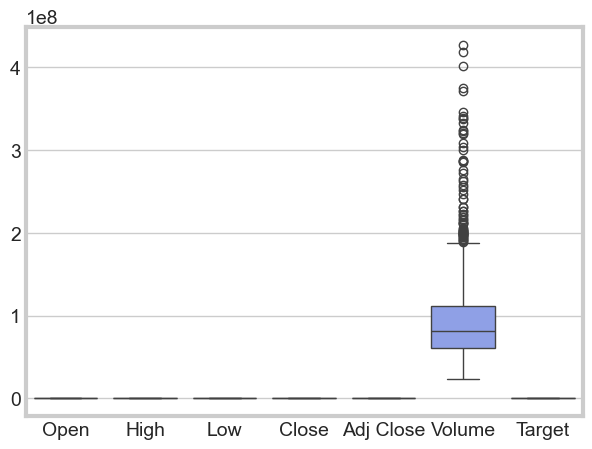

In [54]:
sns.boxplot(data)

In [55]:
# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-08-12  False  False  False  False      False   False
2019-08-13  False  False  False  False      False    True
2019-08-14  False  False  False  False      False   False
2019-08-15  False  False  False  False      False   False
2019-08-16  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-06  False  False  False  False      False   False
2024-08-07  False  False  False  False      False   False
2024-08-08  False  False  False  False      False   False
2024-08-09  False  False  False  False      False   False
2024-08-12  False  False  False  False      False   False

[5036 rows x 6 columns]


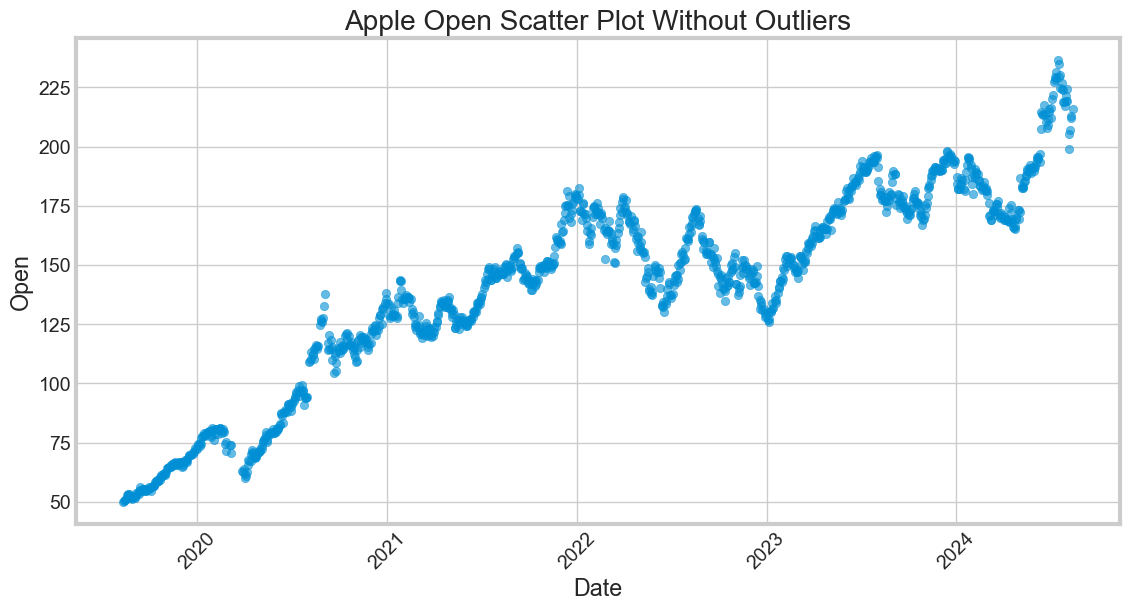

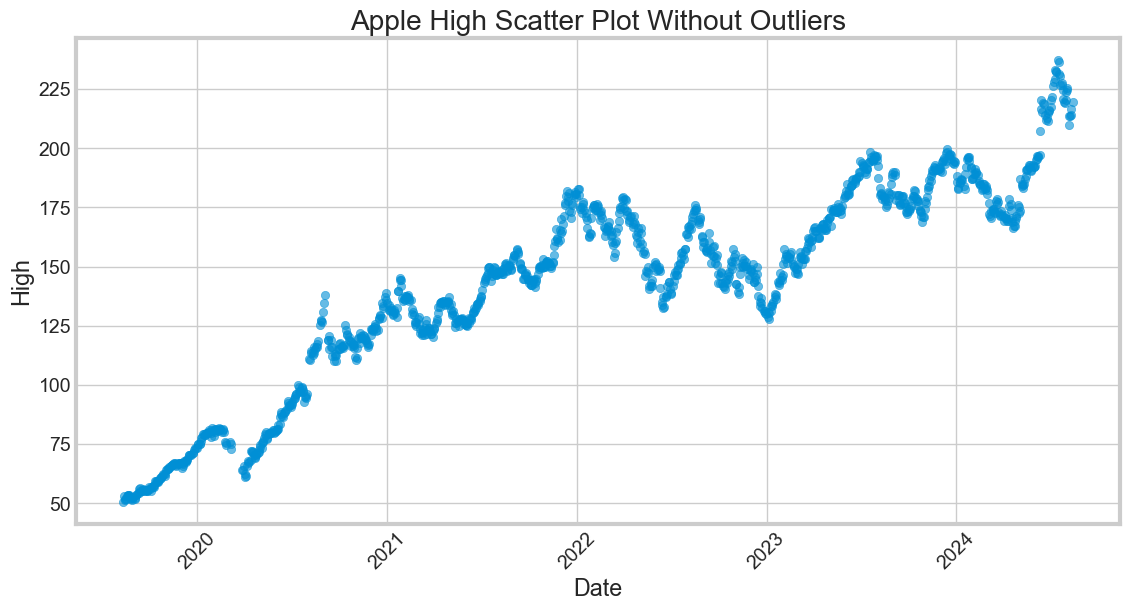

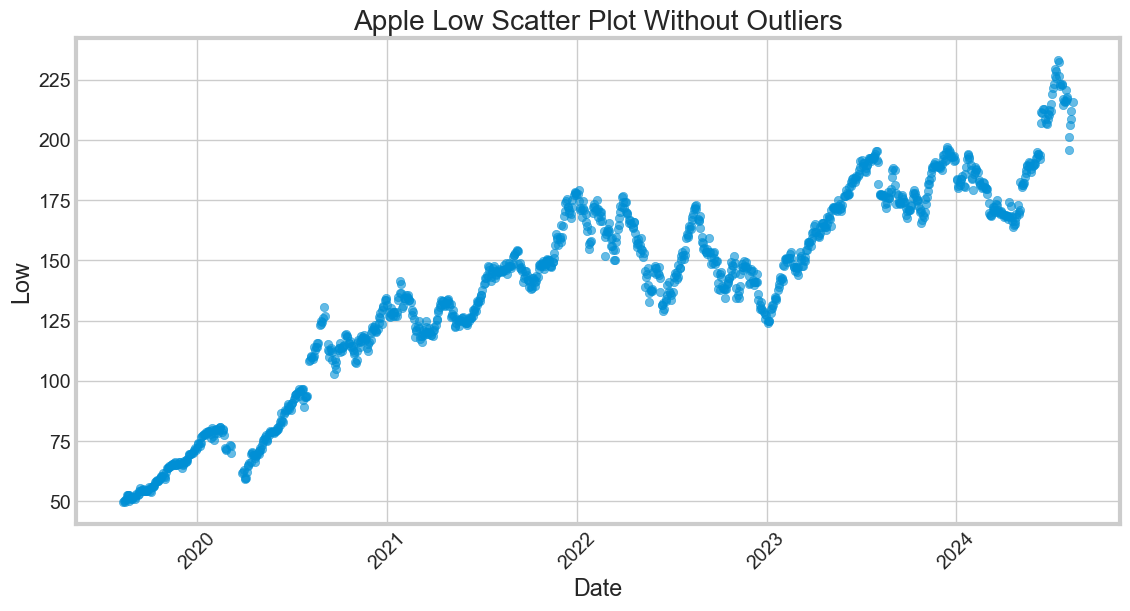

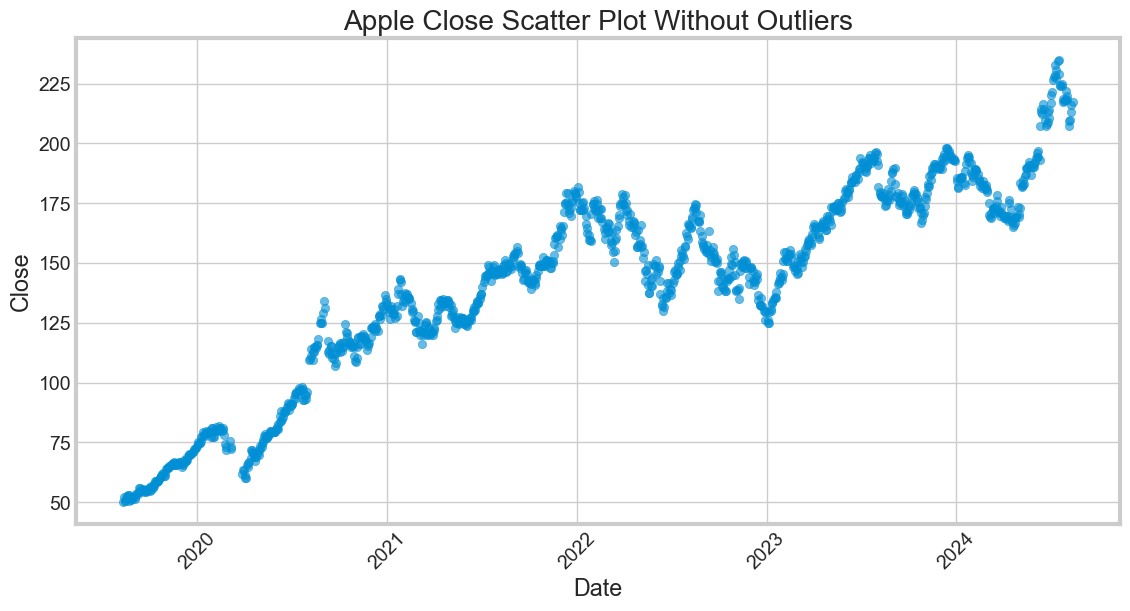

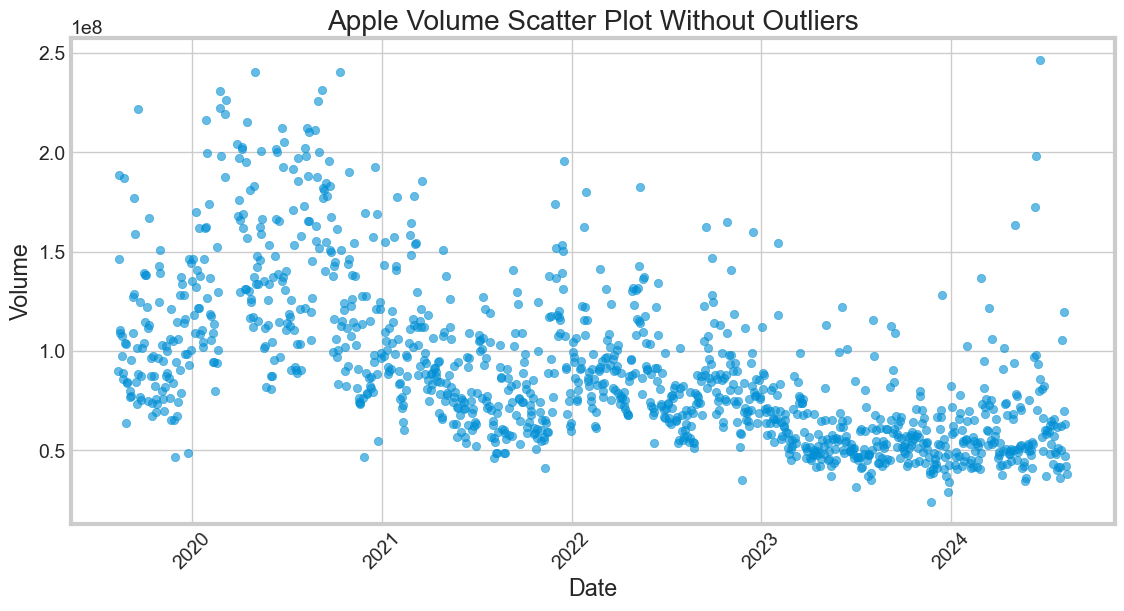

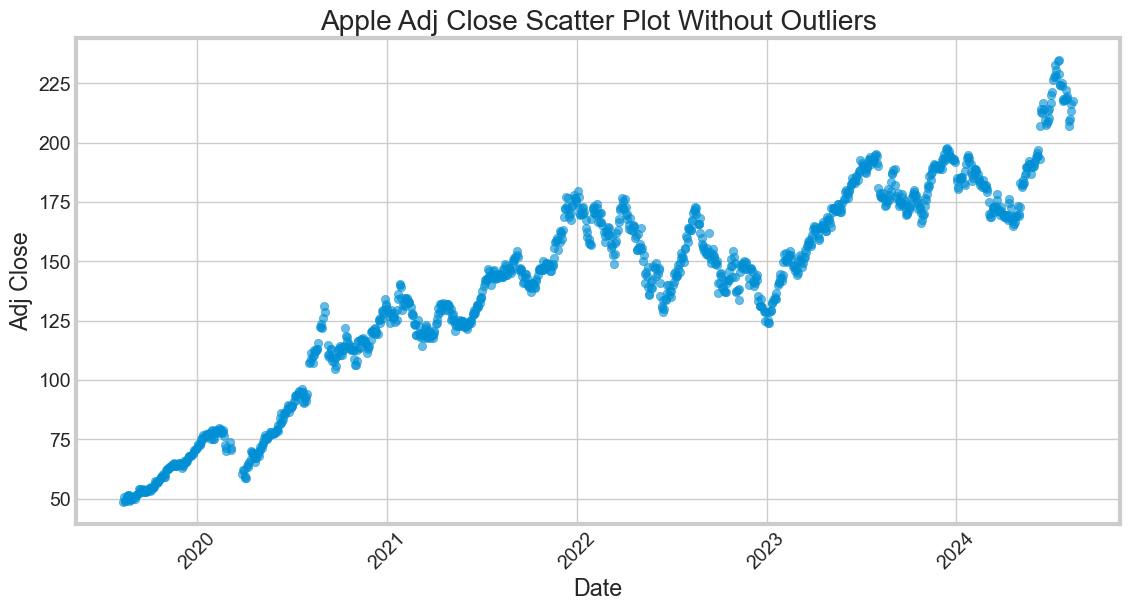

In [56]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [90]:
# Display the first few rows of the dataset to understand its structure
print("First 5 rows of the dataset:")
data_cleaned.head()

First 5 rows of the dataset:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2019-08-12,49.904999,50.512501,49.787498,50.119999,89927600,48.554455
2019-08-13,50.255001,53.035000,50.119999,52.242500,188874000,50.610657
2019-08-14,50.790001,51.610001,50.647499,50.687500,146189600,49.104229
2019-08-15,50.865002,51.285000,49.917500,50.435001,108909600,48.859615
2019-08-16,51.070000,51.790001,50.959999,51.625000,110481600,50.012444


In [91]:
# Display the last few rows of the dataset to understand its structure
print("Last 5 rows of the dataset:")
data_cleaned.tail()

Last 5 rows of the dataset:


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2024-08-06,205.300003,209.990005,201.070007,207.229996,69660500,207.229996
2024-08-07,206.899994,213.639999,206.389999,209.820007,63516400,209.820007
2024-08-08,213.110001,214.199997,208.830002,213.309998,47161100,213.309998
2024-08-09,212.100006,216.779999,211.970001,216.240005,42201600,216.240005
2024-08-12,216.070007,219.509995,215.600006,217.529999,37992400,217.529999


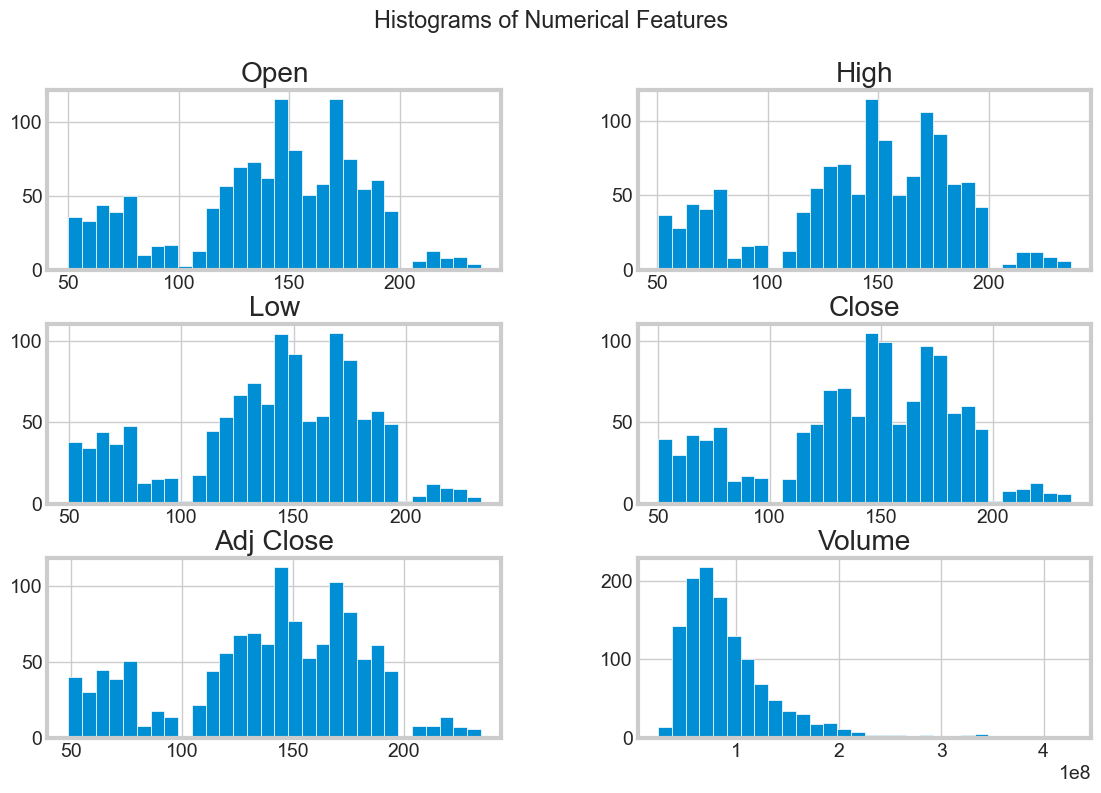

In [93]:
# Visualize the distribution of numerical features
numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_cleaned[numerical_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()
#The graphs for Open/High/Low/Close/Adj Close show us a similar pattern:
#The stocks were usually sold at around 150, 
#Volume wise we see its mostly at around 60 

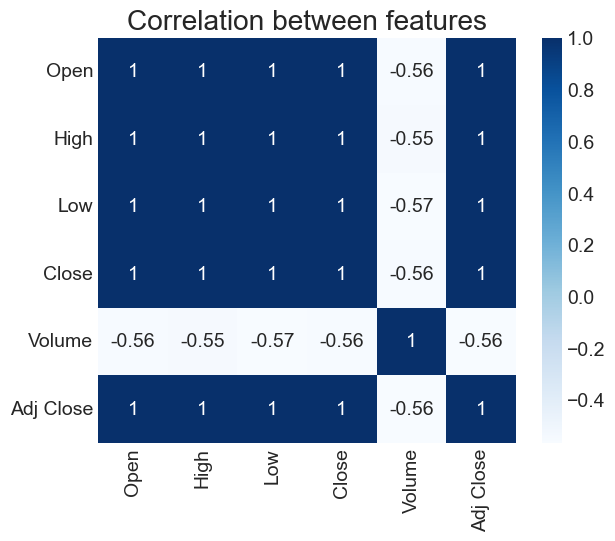

In [96]:
# A higher (darker) value represents higher correlation between the variables
# A lower (lighter) value represents lower correlation between the variables

plt.figure(figsize=(6,5))
#data_disp = df.drop('company_name', axis=1)
plt.title("Correlation between features")
sns.heatmap(data_cleaned.corr(), cmap='Blues', annot=True);

# There's a high correlation between 5 of the features (Open, High, Low, Close, Adj Close)
# There's a negative correlation between those features and the volume

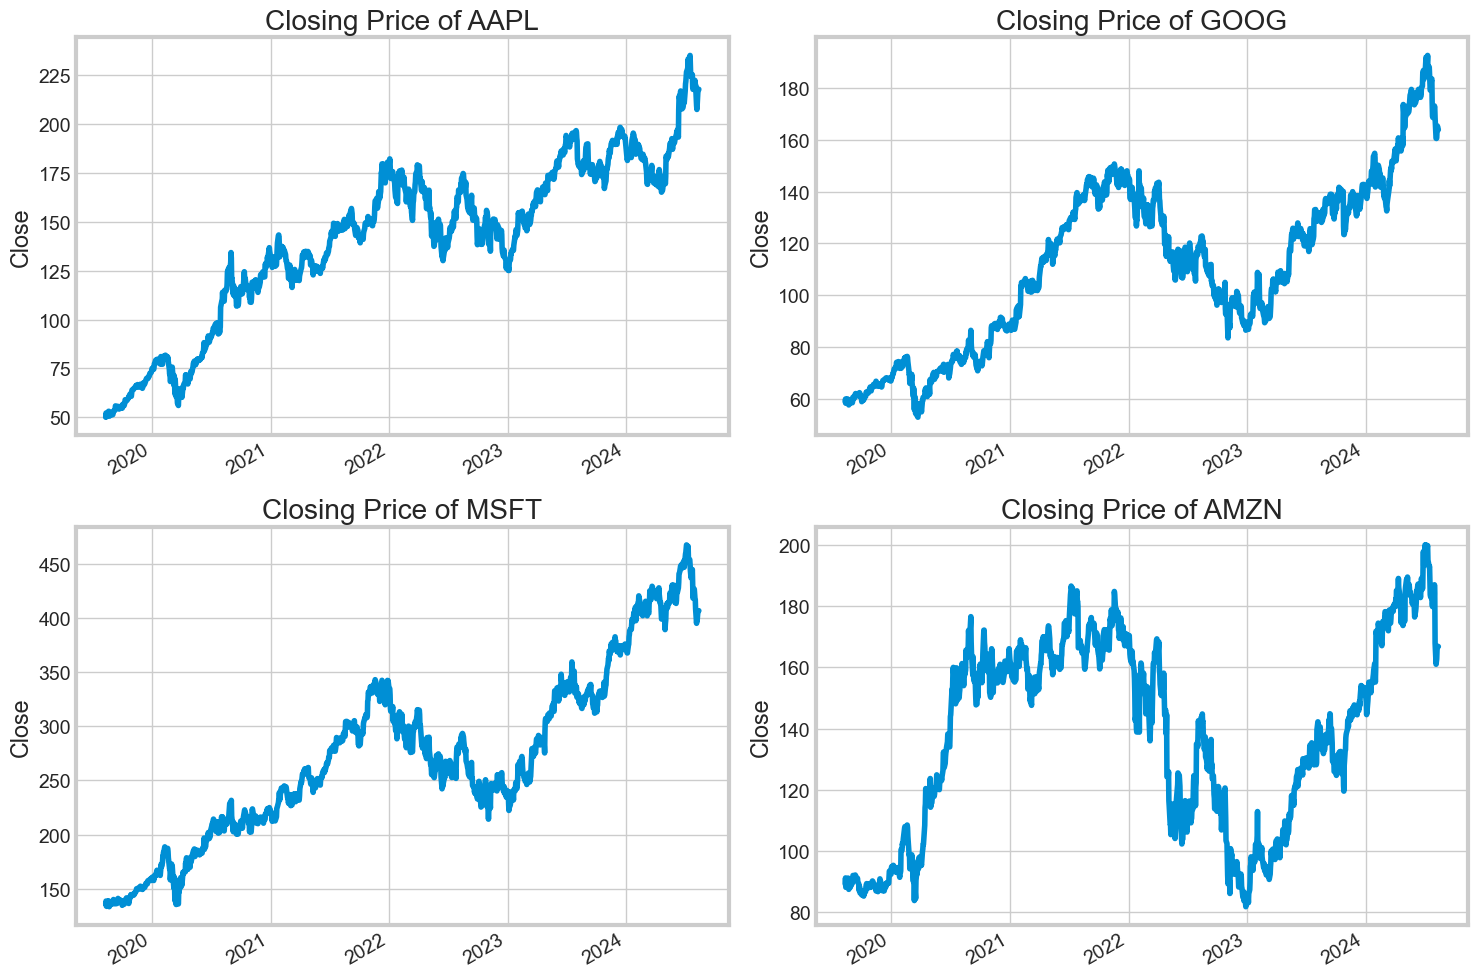

In [62]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

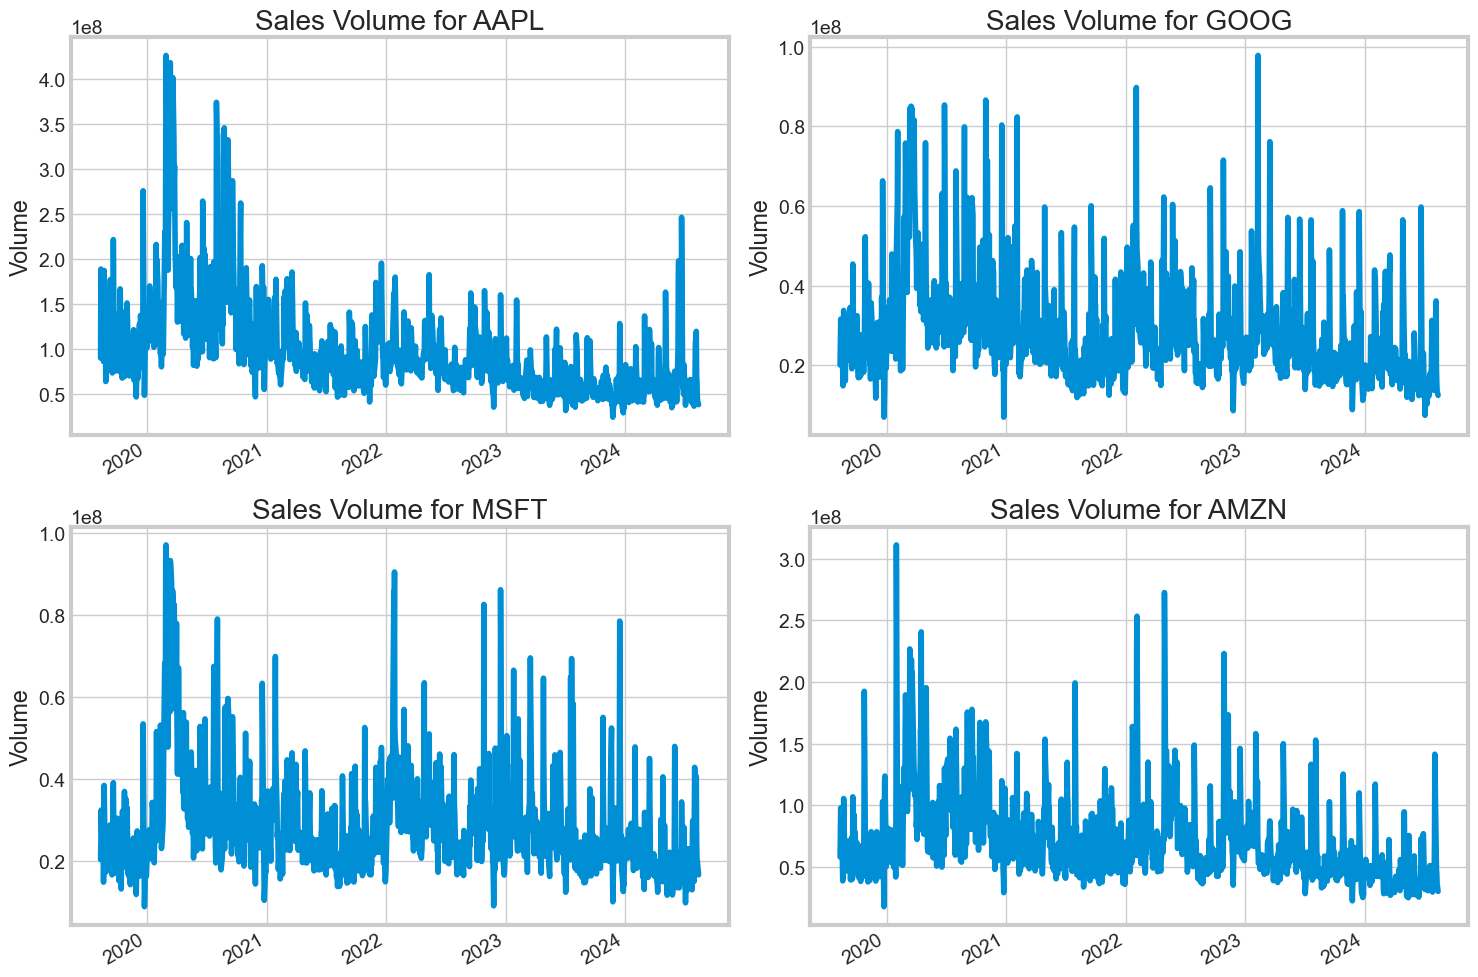

In [63]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()
#looks like volume increases monthly (or periodically)

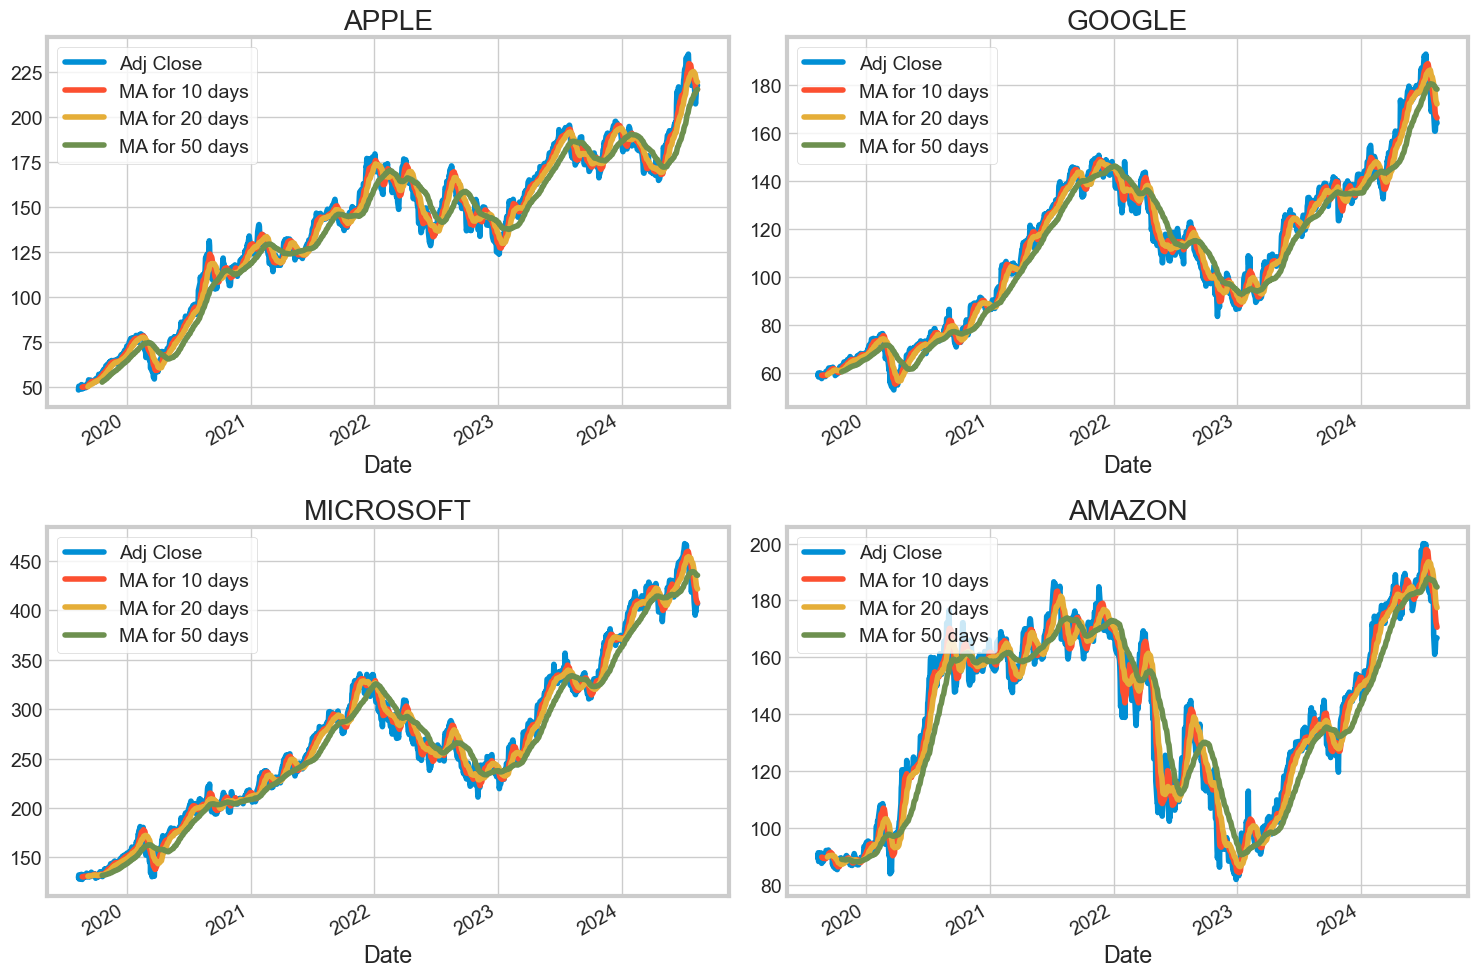

In [64]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

company_data['GOOG'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

company_data['MSFT'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

company_data['AMZN'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()
#best value to measure is 10-20 days: captures trends w/out noise

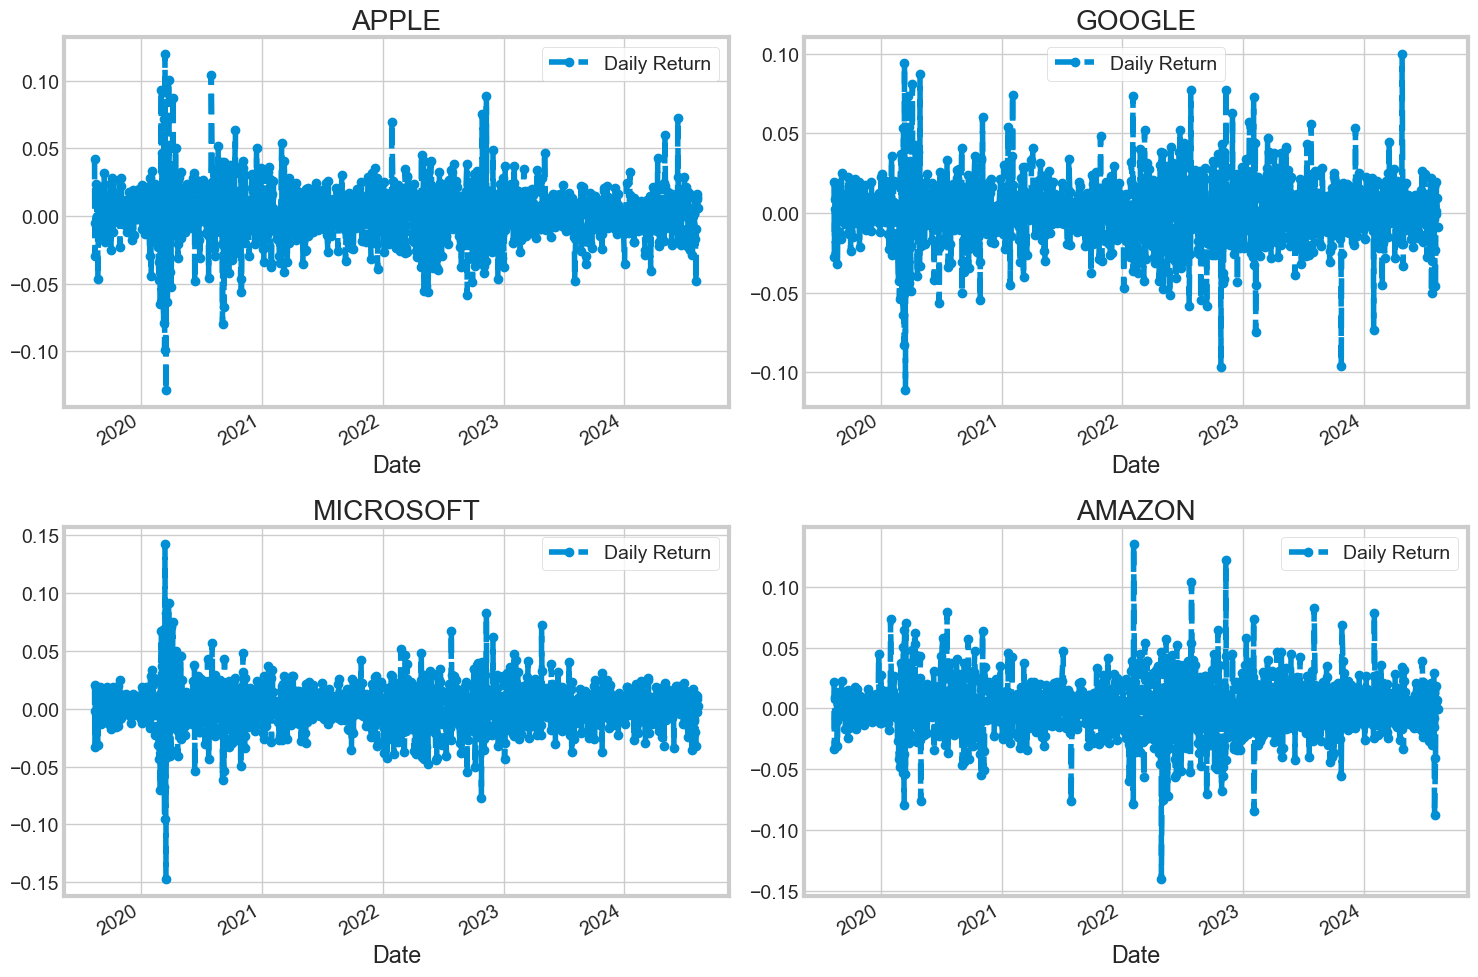

In [65]:
# What was the daily return of the stock on average?
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

company_data['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

company_data['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

company_data['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

#Harder to interpret, but it easily highlights when the daily returns were really high/low


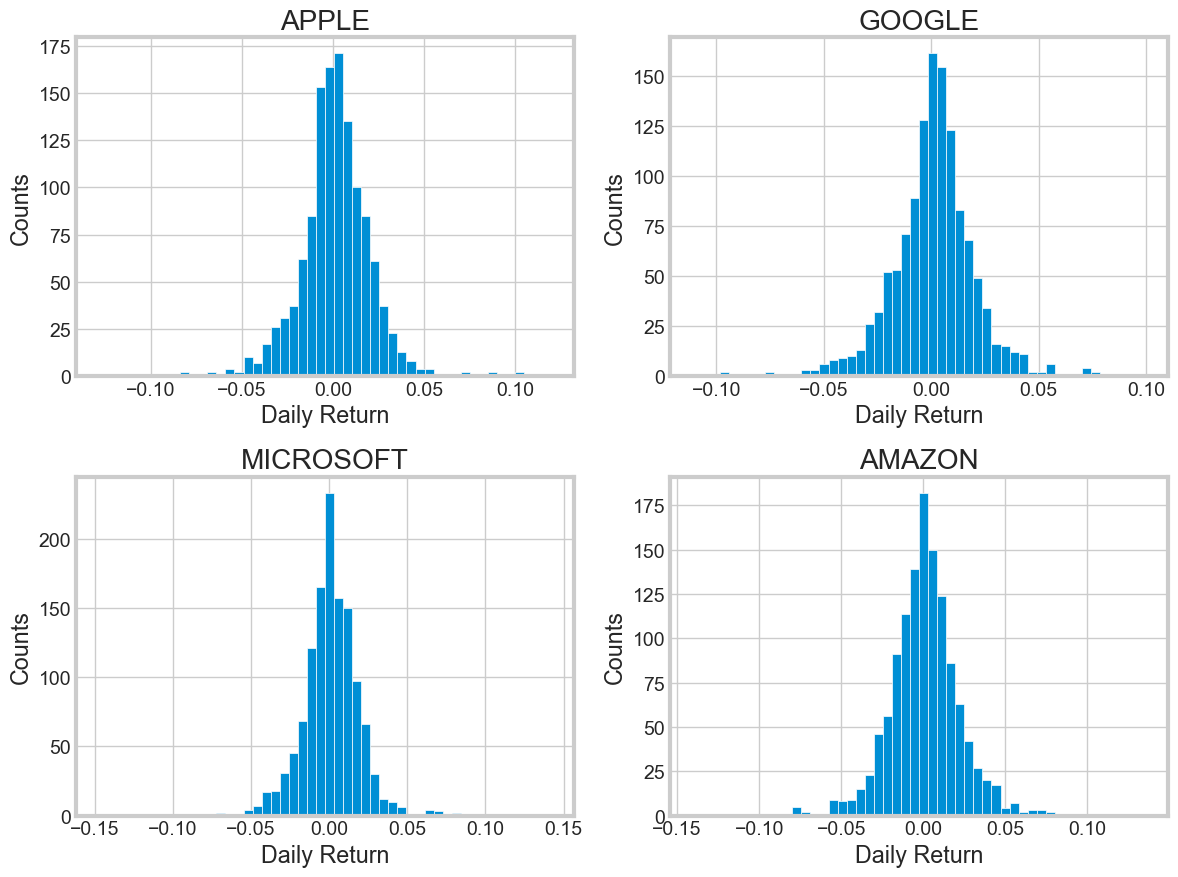

In [66]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()
#Allows us to see how risky a stock is
#How likely is the stock to lose/gain value and by how much
#Google looks to have gained the most at once
#However, Apple seems to be the best probabilities 

In [67]:
#4. What was the correlation between different stocks closing prices?
# Grab all the closing prices for the tech stock list into one DataFrame
close_prices = pd.DataFrame({tech_list[i]: company['Close'] for i, company in enumerate(company_list)})

# Make a new tech returns DataFrame
tech_rets = close_prices.pct_change()
tech_rets.head()

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2019-08-12,NaN,NaN,NaN,NaN
2019-08-13,0.042348,0.019205,0.020694,0.022085
2019-08-14,-0.029765,-0.027546,-0.033333,-0.033645
2019-08-15,-0.004981,0.002551,-0.002239,0.007465
2019-08-16,0.023595,0.008858,0.018327,0.009262


<Figure size 600x500 with 0 Axes>

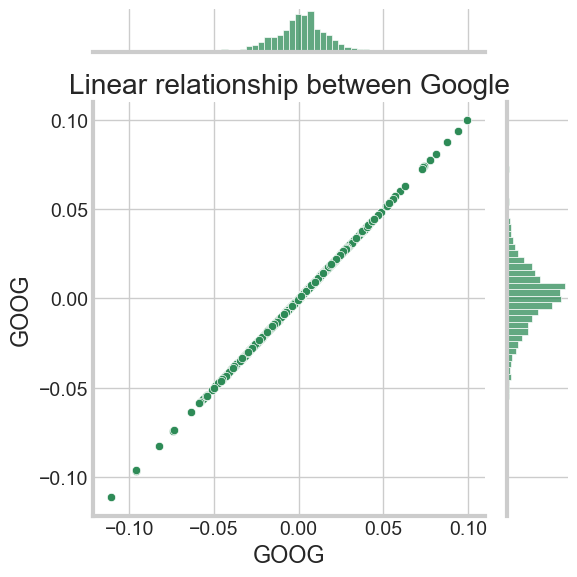

In [68]:
# Comparing Google to itself should show a perfectly linear relationship
plt.figure(figsize=(6, 5))

sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

plt.title("Linear relationship between Google")
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

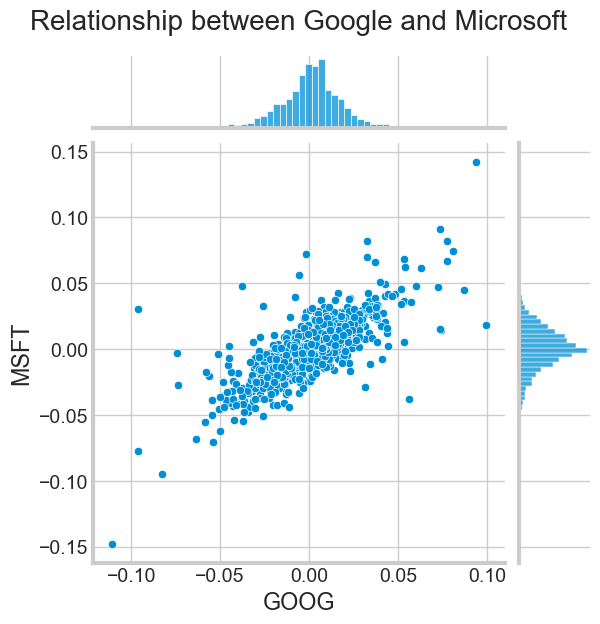

In [69]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
plt.figure(figsize=(10, 10))

sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

plt.title("Relationship between Google and Microsoft", fontsize=20,y=1.25)
plt.show()

<Figure size 3600x3600 with 0 Axes>

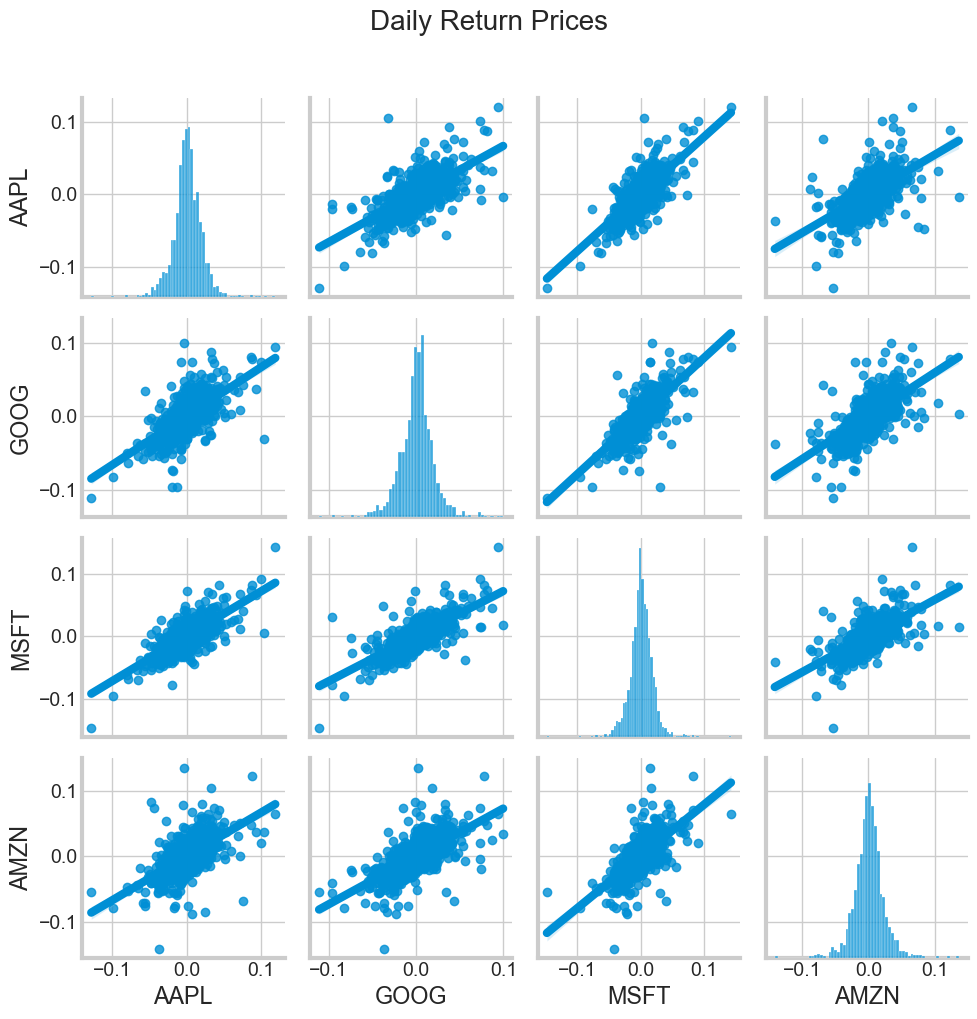

In [70]:
# We can simply call pair plot on our DataFrame for an automatic visual analysis 
# of all the comparisons
plt.figure(figsize=(36, 36))

sns.pairplot(tech_rets, kind='reg')

plt.suptitle("Daily Return Prices", fontsize=20,y=1.02) 
plt.tight_layout()
plt.show()
#Most correlation (daily return) between google and amazon

<Figure size 3600x3000 with 0 Axes>

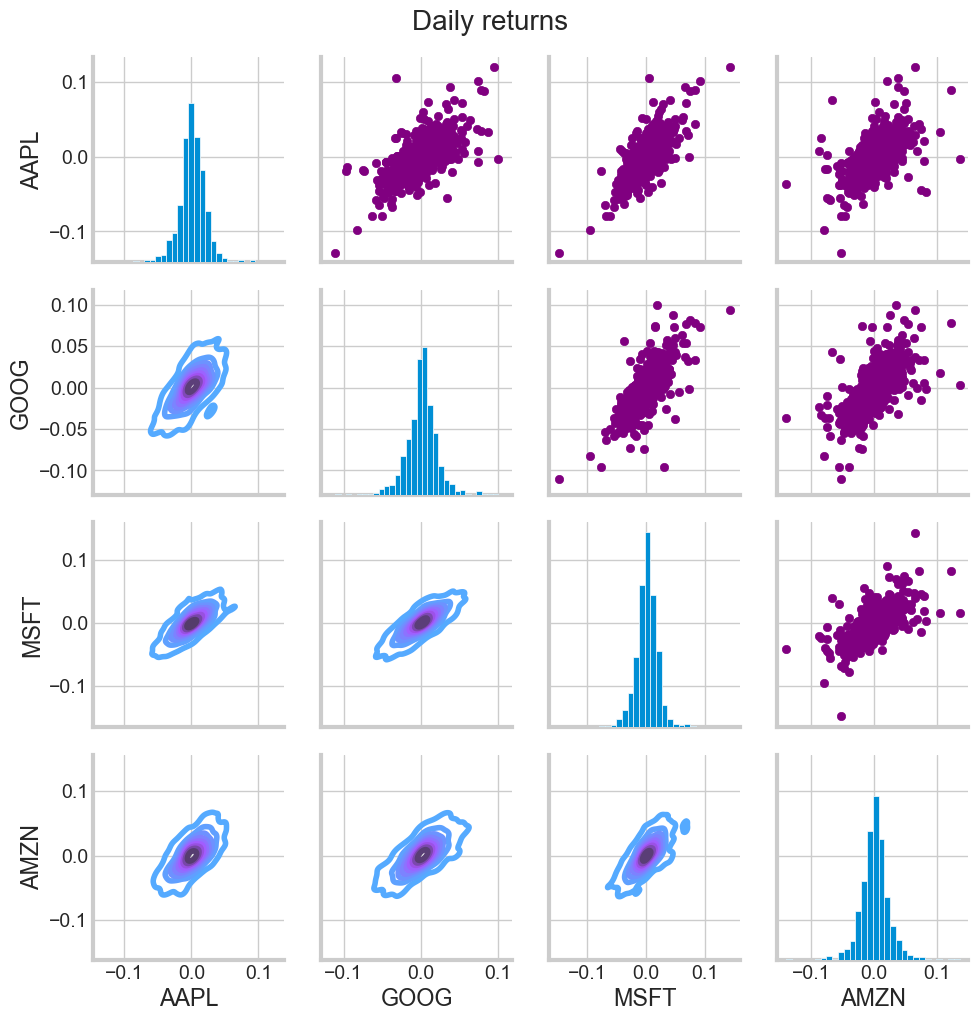

In [71]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, including the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

plt.title("Daily returns",fontsize=20,x=-1.50,y=4.5)
#plt.tight_layout()
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#Microsoft and Google have the best correlation (daily return) once again.

<Figure size 3600x3000 with 0 Axes>

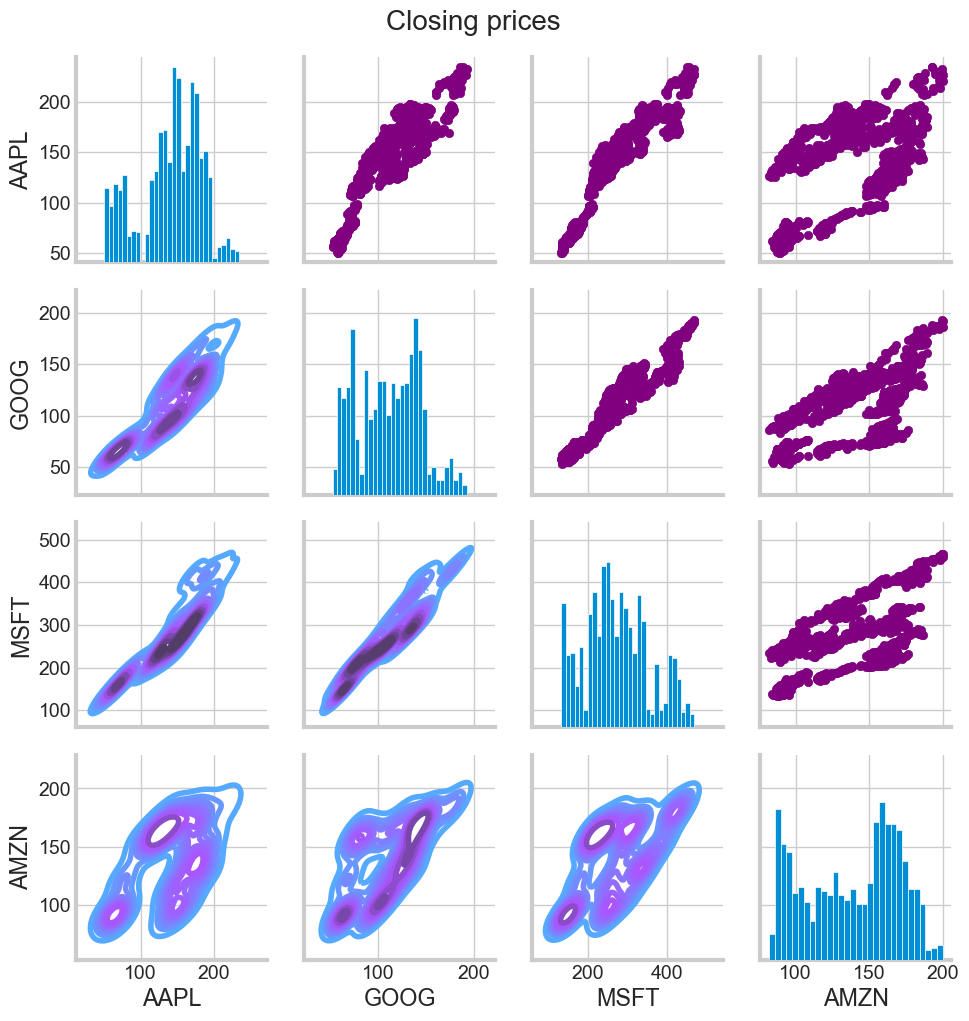

In [72]:
plt.figure(figsize=(36, 30))

# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(close_prices)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

plt.title("Closing prices",fontsize=20,x=-1.50,y=4.5)
plt.show()

#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#It's clear that Microsoft and Amazon are the best correlated for closing prices

Text(0.5, 1.0, 'Correlation of stock closing price')

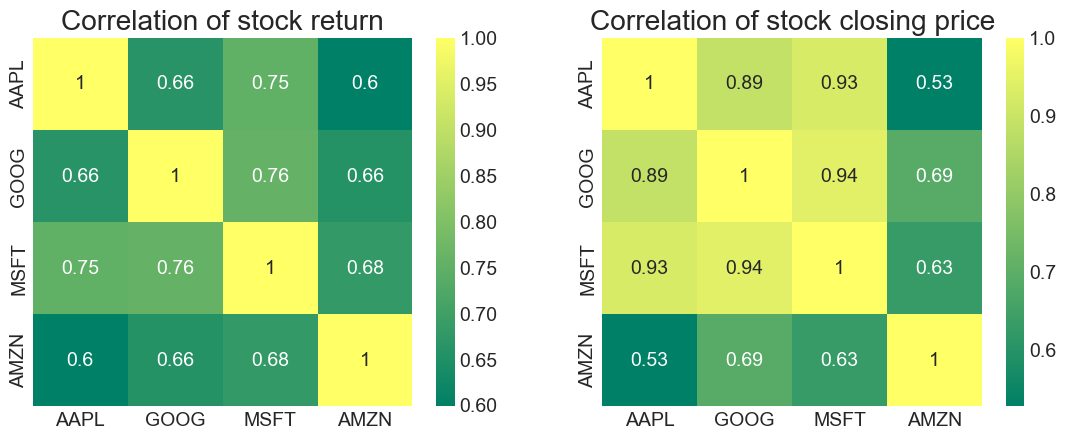

In [73]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(close_prices.corr(), annot=True, cmap='summer', color='purple')
plt.title('Correlation of stock closing price')
#There's a high correlation between AAPL and MSFT second to GOOG and MSFT

In [74]:
# Calculate percentage returns
tech_rets = close_prices.pct_change().dropna()

# Calculate standard deviation of adjusted close prices
std_dev_closing = close_prices.std()

# Calculate standard deviation of returns
std_dev_rets = tech_rets.std()

# Display the standard deviations
print("Standard Deviation of Closing Prices (last 5 years):")
print(std_dev_closing)
print("\nStandard Deviation of Daily Returns (last 5 years):")
print(std_dev_rets)

Standard Deviation of Closing Prices (last 1 year):
AAPL    41.919298
GOOG    32.348290
MSFT    80.032237
AMZN    31.608237
dtype: float64

Standard Deviation of Daily Returns (last 1 year):
AAPL    0.020075
GOOG    0.020069
MSFT    0.019134
AMZN    0.022307
dtype: float64


In [99]:
#Set Target Variable
#Can filter close either or way
#output_var = pd.DataFrame(data_cleaned, columns=['Close']) 
output_var = data_cleaned.filter(['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']
output_var.tail

<bound method NDFrame.tail of                  Close
Date                  
2019-08-12   50.119999
2019-08-13   52.242500
2019-08-14   50.687500
2019-08-15   50.435001
2019-08-16   51.625000
...                ...
2024-08-06  207.229996
2024-08-07  209.820007
2024-08-08  213.309998
2024-08-09  216.240005
2024-08-12  217.529999

[1231 rows x 1 columns]>

In [100]:
dataset = output_var.values

# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")